In [349]:
import numpy as np
import pandas as pd
from pandas.testing import assert_index_equal
import statsmodels.formula.api as sm
from tqdm import tqdm
from statsmodels.sandbox.regression.gmm import IVGMM
import seaborn as sns
import matplotlib.pyplot as plt

In [350]:
from gmm_class import GMM, GMMResults, NFP, results_class_dict
from consumers import us_census, draw_from_census, draw_from_normal, simulate_consumers
from instruments import HausmanIV, BLPIV, DifferentiationIV
from utils import run_2SLS, run_2SGMM, get_logit_elasticities, get_demand_derivatives_logit

In [351]:
df = pd.read_csv("rcl_data_4.csv")
df.set_index(keys=['mktid','firmid', 'prodid'], inplace=True)
df["log_share"] = np.log(df["share"])

## Summary statistics

In [352]:
df_widxs = df.copy()
df_widxs['firmid'] = df_widxs.index.get_level_values('firmid')
df_widxs['prodid'] = df_widxs.index.get_level_values('prodid')
stats_mktlvl = df_widxs.groupby(by=['mktid']).aggregate({'firmid': 'nunique', 'prodid': 'nunique'})
stats_mktlvl.rename(columns={"firmid": "#Firms", "prodid": "#Products"}, inplace=True)
nfirms = stats_mktlvl["#Firms"]
nprods = stats_mktlvl["#Products"]
df_std = df.groupby('mktid').mean()
df_mean = df.groupby('mktid').median()
stats_mktlvl.join(df_mean.join(df_std,rsuffix='_std',lsuffix='_mean'))

,#Firms,#Products,price_mean,share_mean,xvar_mean,wvar_mean,log_share_mean,price_std,share_std,xvar_std,wvar_std,log_share_std
mktid,,,,,,,,,,,,
1,4,7,2.606675,0.149334,1.952670,-0.370695,-1.901567,2.750983,0.118469,1.945542,-0.293838,-2.483372
2,4,7,2.430668,0.070118,2.685479,-0.564728,-2.657577,2.608820,0.136178,2.631723,-0.270162,-3.416234
3,4,7,2.844954,0.082008,2.660057,-0.126529,-2.500937,3.098984,0.128079,2.576645,0.065384,-3.597887
4,4,11,3.326305,0.009768,1.946938,0.218622,-4.628668,3.530610,0.072886,1.983285,0.168326,-4.950860
5,4,11,2.663987,0.027104,1.946938,-0.089058,-3.608089,2.854352,0.082693,1.801961,-0.154398,-3.747254
6,4,8,2.698184,0.039247,1.949804,0.131254,-3.252579,2.950200,0.106947,1.940615,0.029890,-3.461575
7,3,6,2.966885,0.122192,2.030004,0.142384,-2.121575,2.868110,0.121251,1.825464,-0.006352,-2.290008
8,4,12,3.088131,0.014099,2.077402,0.061042,-4.261649,3.062927,0.073310,2.144377,0.101264,-3.847605
9,4,10,3.246889,0.021610,1.957790,0.171797,-3.875696,3.361858,0.076573,2.155827,0.141241,-3.888033


In [353]:
df_std = df.groupby('mktid').std()
df_mean = df.groupby('mktid').mean()
df_min = df.groupby('mktid').min()
df_max = df.groupby('mktid').max()
stats_mktlvl.join(df_mean.join(df_std.join(df_min.join(df_max, rsuffix='_max'), rsuffix='_min'),rsuffix='_std',lsuffix='_mean'))

,#Firms,#Products,price_mean,share_mean,xvar_mean,wvar_mean,log_share_mean,price_std,share_std,xvar_std,...,price_min,share_min,xvar_min,wvar_min,log_share_min,price_max,share_max,xvar_max,wvar_max,log_share_max
mktid,,,,,,,,,,,,,,,,,,,,,
1,4,7,2.750983,0.118469,1.945542,-0.293838,-2.483372,0.504559,0.083901,0.645296,...,2.310209,0.015946,0.671772,-0.640421,-4.138520,3.783296,0.227237,2.755761,0.164740,-1.481762
2,4,7,2.608820,0.136178,2.631723,-0.270162,-3.416234,0.705770,0.156169,0.432091,...,1.733794,0.000308,1.857874,-1.286910,-8.086862,3.612128,0.409148,3.143323,0.703590,-0.893679
3,4,7,3.098984,0.128079,2.576645,0.065384,-3.597887,0.779273,0.144382,0.471870,...,2.012440,0.001445,1.933339,-0.626037,-6.539659,4.166480,0.369714,3.143323,1.012786,-0.995026
4,4,11,3.530610,0.072886,1.983285,0.168326,-4.950860,0.857782,0.149572,0.740780,...,2.483254,0.000044,0.671772,-0.721385,-10.028818,5.050753,0.498375,3.009212,0.795168,-0.696403
5,4,11,2.854352,0.082693,1.801961,-0.154398,-3.747254,0.846140,0.114486,0.667598,...,1.442446,0.000100,0.671772,-0.612460,-9.205419,4.568714,0.367852,2.755761,0.250892,-1.000074
6,4,8,2.950200,0.106947,1.940615,0.029890,-3.461575,0.778380,0.133469,0.577514,...,2.179758,0.000150,0.671772,-0.949792,-8.806705,4.542324,0.367265,2.660057,0.872742,-1.001671
7,3,6,2.868110,0.121251,1.825464,-0.006352,-2.290008,0.376994,0.066176,0.913509,...,2.191228,0.028310,0.671772,-0.935112,-3.564546,3.203889,0.191099,2.755761,0.796828,-1.654964
8,4,12,3.062927,0.073310,2.144377,0.101264,-3.847605,0.587061,0.138590,0.603179,...,1.890271,0.000790,0.779767,-0.139097,-7.143806,3.928379,0.491212,3.009212,0.699992,-0.710880
9,4,10,3.361858,0.076573,2.155827,0.141241,-3.888033,0.478922,0.119418,0.558861,...,2.739443,0.000681,1.305570,-0.459850,-7.291230,4.237235,0.349676,3.143323,0.559578,-1.050748


## Logit model warmup

### 1. with OLS

To Do: add a constant in the dataset, as 2SLS does not add one by default

In [354]:
logit_ols = sm.ols(formula="log_share ~ xvar + price", data=df).fit()
print(logit_ols.summary())

                            OLS Regression Results                            
Dep. Variable:              log_share   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     340.1
Date:                Thu, 02 Feb 2023   Prob (F-statistic):           1.07e-62
Time:                        23:21:30   Log-Likelihood:                -274.26
No. Observations:                 188   AIC:                             554.5
Df Residuals:                     185   BIC:                             564.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.4678      0.360      4.073      0.0

eval_env: 1


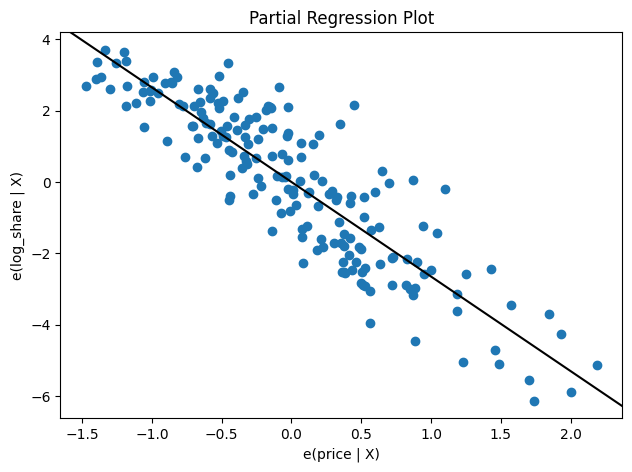

In [355]:
# Partial Regression Plot of logshare-E[logshare|xvar] on price-E[price|xvar]
import statsmodels.api as sm_
fig = sm_.graphics.plot_partregress("log_share", "price", ["xvar"], data=df, obs_labels = False)
fig.tight_layout(pad=1.0)

### 2. With 2SLS

In [356]:
logit_2sls = run_2SLS(df, ["wvar"])

                          IV2SLS Regression Results                           
Dep. Variable:              log_share   R-squared:                       0.785
Model:                         IV2SLS   Adj. R-squared:                  0.783
Method:                     Two Stage   F-statistic:                     86.48
                        Least Squares   Prob (F-statistic):           3.04e-27
Date:                Thu, 02 Feb 2023                                         
Time:                        23:21:31                                         
No. Observations:                 188                                         
Df Residuals:                     185                                         
Df Model:                           2                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6599      0.583      2.846      0.0

### GMM

In [357]:
logit_2sgmm = run_2SGMM(df, ["wvar"])

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 8
         Function evaluations: 10
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
                                IVGMM Results                                 
Dep. Variable:              log_share   Hansen J:                    1.403e-11
Model:                          IVGMM   Prob (Hansen J):                   nan
Method:                           GMM                                         
Date: 

In [414]:
def get_logit_elasticities(mktid: int) -> pd.DataFrame:
    constant, alpha, beta = logit_2sgmm.params
    df_mkt = df[df.index.get_level_values('mktid')==mktid].droplevel('mktid')
    N = df_mkt["price"].shape[0]
    mkt_elst = -alpha*np.dot(np.ones((N,1)), (df_mkt["price"]*df_mkt["share"]).to_numpy().reshape((1,N))) + alpha*np.diag(df_mkt["price"])
    return pd.DataFrame(mkt_elst, index=df_mkt.index, columns=df_mkt.index)

def get_demand_derivatives_logit(mktid: int) -> pd.DataFrame:
    constant, alpha, beta = logit_2sgmm.params
    df_mkt = df[df.index.get_level_values('mktid')==mktid].droplevel('mktid')
    N = df_mkt["share"].shape[0]
    dqdp = np.array(-alpha*np.outer(df_mkt["share"],df_mkt["share"]))
    diag = list(alpha*df_mkt["share"]*(1-df_mkt["share"]))
    np.fill_diagonal(dqdp, diag)
    return pd.DataFrame(dqdp, index=df_mkt.index, columns=df_mkt.index)


Matrix of own and cross-price elasticities for market 1:

In [415]:
get_demand_derivatives_logit(1)

,prodid,5,7,8,14,16,17,18
,firmid,1,2,2,3,4,4,4
prodid,firmid,,,,,,,
5,1,-0.479637,0.009898,0.108762,0.092689,0.111259,0.021972,0.029098
7,2,0.009898,-0.042862,0.007632,0.006504,0.007808,0.001542,0.002042
8,2,0.108762,0.007632,-0.394757,0.071476,0.085796,0.016944,0.022439
14,3,0.092689,0.006504,0.071476,-0.346981,0.073117,0.014440,0.019123
16,4,0.111259,0.007808,0.085796,0.073117,-0.401851,0.017333,0.022954
17,4,0.021972,0.001542,0.016944,0.014440,0.017333,-0.093270,0.004533
18,4,0.029098,0.002042,0.022439,0.019123,0.022954,0.004533,-0.122050


## Computing Instrumental Variables

In [416]:
df = HausmanIV(df)
df = BLPIV(df)
df = DifferentiationIV(df)

14.562190736471745 3.2527472527472527 13.873626373626374 15.81868131868132


In [417]:
logit_2sls_hausman = run_2SLS(df, ["hausman_iv"])

                          IV2SLS Regression Results                           
Dep. Variable:              log_share   R-squared:                       0.784
Model:                         IV2SLS   Adj. R-squared:                  0.781
Method:                     Two Stage   F-statistic:                     97.55
                        Least Squares   Prob (F-statistic):           2.23e-29
Date:                Thu, 02 Feb 2023                                         
Time:                        23:42:01                                         
No. Observations:                 182                                         
Df Residuals:                     179                                         
Df Model:                           2                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3328      0.592      3.941      0.0

Checking df has correctly been added hte instruments:

## Random Coefficients Logit Model

In [418]:
inst = ['xvar', 'wvar', 'log_share', 'hausman_iv', 'blp1',
       'blp2', 'blp3', 'blp4', 'diff_iv', 'diff_iv_prodband0',
       'diff_iv_prodband1', 'diff_iv_prodband2']
df[inst].std()

xvar                  0.640336
wvar                  0.479375
log_share             2.243852
hausman_iv            0.498113
blp1                  1.822958
blp2                  1.928350
blp3                  2.165911
blp4                  3.943147
diff_iv              20.382944
diff_iv              20.382944
diff_iv              20.382944
diff_iv_prodband0     5.002968
diff_iv_prodband0     5.002968
diff_iv_prodband0     5.002968
diff_iv_prodband1     4.247907
diff_iv_prodband1     4.247907
diff_iv_prodband1     4.247907
diff_iv_prodband2     4.695723
diff_iv_prodband2     4.695723
diff_iv_prodband2     4.695723
dtype: float64

In [18]:
cons = simulate_consumers(n=100)

In [216]:
nfp = NFP(df, cons, instruments=['xvar', 'wvar', 'hausman_iv', 'blp1',
       'blp2', 'blp3', 'blp4', 'diff_iv', 'diff_iv_prodband0',
       'diff_iv_prodband1', 'diff_iv_prodband2'], tol_fp=1e-4)
theta2_0=np.random.rand(1,2)

In [217]:
# Check for full-rank instrument matrix
instr_noconst = list(set(nfp.Z.columns).difference(["const"]))
instr_corr = nfp.Z[instr_noconst].corr()
instr_rk = np.linalg.matrix_rank(instr_corr)
print("Instrument matrix of rank {0:d}/{1:d}".format(instr_rk, len(instr_noconst)))

# Instrument matrix condtion number
print("Condition number of correlation matrix: {0:.2f}".format(np.linalg.cond(instr_corr)))

Instrument matrix of rank 11/11
Condition number of correlation matrix: 50248316773527640.00


In [218]:
nfp.verbose = False
nfp_res = nfp.fit(theta2_0, optim_method="nm", maxiter=0)

Optimization terminated successfully.
         Current function value: 1.424387
         Iterations: 44
         Function evaluations: 90


### Parameters

In [368]:
const, alpha, beta, pi1, pi2, ϵ, μ, δ = get_params_nfp(nfp_res)
delta = pd.read_csv('/Users/pranjal/Desktop/Structural-Economics/industrial-organization/3_diff_prod_rand_logit/delta.csv')
mu = pd.read_csv('/Users/pranjal/Desktop/Structural-Economics/industrial-organization/3_diff_prod_rand_logit/mu.csv')
delta.drop('Unnamed: 0', axis = 1, inplace = True)
mu.drop('Unnamed: 0', axis = 1, inplace = True)
δ = pd.DataFrame(np.array(delta.iloc[0:182]), index=δ.index)
μ = pd.DataFrame(np.array(mu.iloc[0:182]), index=μ.index, columns = μ.columns)
print(const, alpha, beta, pi1, pi2)

5.647669825906114 -3.2351932522614475 1.9450657878212865 1.730049246357518 0.7560857783514928


In [378]:
def get_demand_derivatives_nfp(nfp_res, cons, t):
    const, alpha, beta, pi1, pi2, ξ, μ, δ = get_params_nfp(nfp_res)
    df_mkt = df[df.index.get_level_values('mktid')==t]
    δ = δ[δ.index.get_level_values('mktid')==t]
    μ = μ[μ.index.get_level_values('mktid')==t]
    I = cons.shape[0]
    J = df_mkt.index.get_level_values('prodid').unique()
    sharei = get_shares(nfp_res, cons, df)
    s = sharei[sharei.index.get_level_values('mktid')==t]
    dqdp = np.zeros((J.shape[0], J.shape[0]))
    for ji,j in enumerate(J):
        p_jt = df_mkt[df_mkt.index.get_level_values('prodid')==j].price
        s_jt = df_mkt[df_mkt.index.get_level_values('prodid')==j].share
        for ki,k in enumerate(J):         
            if j==k: 
                val = 0
                for i in range(I):
                    val+=alpha*s.iloc[ji, i]*(1-s.iloc[ki, i])
                dqdp[ji,ki]= val/100 # * p_jt/s_jt              
            else:
                val = 0
                for i in range(I):
                    val+=-alpha*s.iloc[ji, i]*s.iloc[ki, i]
                dqdp[ji,ki]= val/100 #* -p_jt/s_jt
    return pd.DataFrame(dqdp, index=df_mkt.index, columns=df_mkt.index)
  
def get_shares(nfp_res, cons, df):
    const, alpha, beta, pi1, pi2, ξ, μ, δ = get_params_nfp(nfp_res)
    df2 = df.reset_index()
    mktid = df2.mktid
    μ_ = μ.to_numpy() + δ.to_numpy().reshape(-1,1)
    eg = np.exp(μ_)
    eg = pd.DataFrame(eg, index = μ.index)
    temp = eg.groupby('mktid').sum()
    temp2 = 1+temp
    eg = eg.reset_index()
    eg.drop(['firmid','prodid'], axis = 1, inplace = True)
    a = eg.T
    b = temp2.T
    new_header = a.iloc[0].astype(int).astype(str) #grab the first row for the header
    a = a[1:] #take the data less the header row
    a.columns = new_header
    b.columns = [str(i) for i in b.columns ]
    x = pd.merge(a, b, left_index = True, right_index = True, suffixes=('', '_b'), indicator=True)
    sharei = np.zeros((100, 182))
    for i,m in enumerate(df2.mktid): 
        sharei[:, i] = a.iloc[:, i]/b.iloc[:,int(m-1)]
    sharei = pd.DataFrame(sharei.T, index = μ.index, columns = μ.columns)
    return sharei        
        
def get_params_nfp(nfp_res):
    const, alpha, beta = nfp_res['theta1_est']
    pi1, pi2 = nfp_res['theta2_est']
    ϵ = nfp_res['dmdshift_est']
    μ = nfp_res['mu_est']
    δ = nfp_res['delta_est']
    return const, alpha, beta, pi1, pi2, ϵ, μ, δ

def get_xi(nfp_res, df):
    const, alpha, beta, pi1, pi2, ϵ, μ, δ = get_params_nfp(nfp_res)
    ξ = δ-alpha*df.price-beta*df.xvar
    return ξ

### Demand Derivatives

In [379]:
get_demand_derivatives_nfp(nfp_res, cons, 1)

mktid                       1                                          \
prodid                     5         7         8         14        16   
firmid                      1         2         2         3         4   
mktid prodid firmid                                                     
1     5      1      -0.548980  0.013844  0.139252  0.117264  0.148818   
      7      2       0.013844 -0.050423  0.009750  0.008026  0.011371   
      8      2       0.139252  0.009750 -0.459747  0.091200  0.109879   
      14     3       0.117264  0.008026  0.091200 -0.405196  0.092079   
      16     4       0.148818  0.011371  0.109879  0.092079 -0.460264   
      17     4       0.027788  0.001901  0.021619  0.018475  0.021817   
      18     4       0.030801  0.001554  0.027479  0.024687  0.022684   

mktid                                    
prodid                     17        18  
firmid                      4         4  
mktid prodid firmid                      
1     5      1       0.027788  0.030801  
      7      2       0.001901  0.001554  
      8      2       0.021619  0.027479  
      14     3       0.018475  0.024687  
      16     4       0.021817  0.022684  
      17     4      -0.110147  0.005861  
      18     4       0.005861 -0.137715

In [380]:
# compared with logit - we can see much more substitution!
get_demand_derivatives_logit(1)

,prodid,5,7,8,14,16,17,18
,firmid,1,2,2,3,4,4,4
prodid,firmid,,,,,,,
5,1,-0.479637,0.009898,0.108762,0.092689,0.111259,0.021972,0.029098
7,2,0.009898,-0.042862,0.007632,0.006504,0.007808,0.001542,0.002042
8,2,0.108762,0.007632,-0.394757,0.071476,0.085796,0.016944,0.022439
14,3,0.092689,0.006504,0.071476,-0.346981,0.073117,0.014440,0.019123
16,4,0.111259,0.007808,0.085796,0.073117,-0.401851,0.017333,0.022954
17,4,0.021972,0.001542,0.016944,0.014440,0.017333,-0.093270,0.004533
18,4,0.029098,0.002042,0.022439,0.019123,0.022954,0.004533,-0.122050


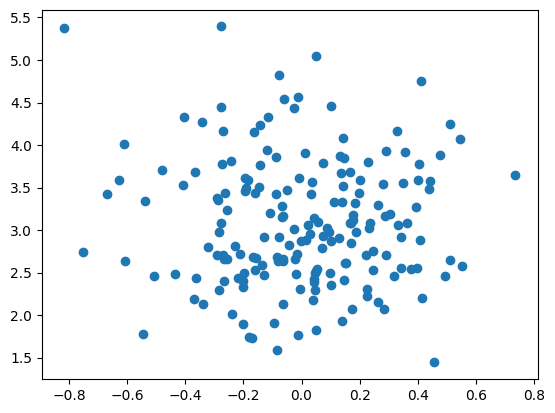

In [419]:
def get_xi(nfp_res, cons, df2):
    const, alpha, beta, pi1, pi2, ϵ, μ, δ = get_params_nfp(nfp_res)
    a = np.dot(cons.iloc[:, 0:2].to_numpy(), np.array([pi1,pi2]))
    ξ = δ - (const + alpha*df2.price+beta*df2.xvar).to_numpy()
    return ξ

ξ = get_xi(nfp_res, cons, df2)
ξ.shape
plt.scatter(ξ,df2.price)

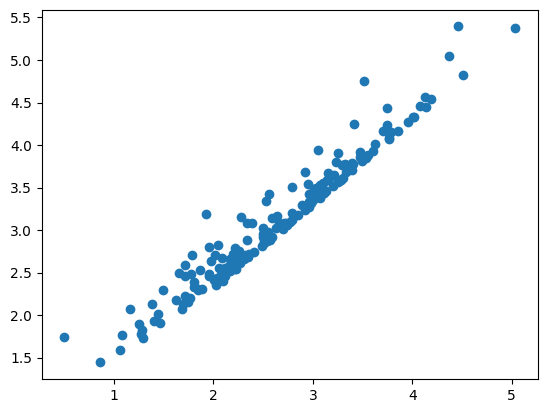

In [420]:
plt.scatter(df2.mc,df2.price)

# Marginal Costs

In [421]:
def ownership(mktid):
    "input: market id, demand derivative matrix"
    "output: ownership matrix"
    dqdp = get_logit_elasticities(mktid)
    dqdp = dqdp.reset_index()
    F = dqdp.firmid.unique()
    J = dqdp.prodid.unique()
    Ω = np.zeros((len(J),len(J)))
    for ji,j in enumerate(J):
        for ki,k in enumerate(J):
            if dqdp[dqdp.prodid==j].firmid.item() == dqdp[dqdp.prodid==k].firmid.item(): 
                Ω[ji,ki] = 1
    return Ω
ownership(1)

array([[1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 1., 0., 0., 0., 0.],
       [0., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1.]])

In [422]:
def imputeMaginalCost(df):
    df2 = df.reset_index()
    M = df2.mktid.unique()
    df2['mc']=0
    for mi,m in enumerate(M):
        dqdp = get_demand_derivatives_nfp(nfp_res, cons, m)
        prodid = df2[df2.mktid==m]['prodid']
        firmid = df2[df2.mktid==m]['firmid']
        p = df2[df2.mktid==m]['price']
        s = df2[df2.mktid==m]['share']
        Ω = ownership(m)
        c = p + np.dot(np.linalg.inv(Ω*dqdp.T),s)
        df2.loc[(df2.mktid==m), 'mc']=c
    df2 = df2.set_index(['prodid', 'firmid', 'mktid'])
    return df2
df2 = imputeMaginalCost(df)
df2.head()

,,,price,share,xvar,wvar,log_share,hausman_iv_x,blp1,blp2,blp3,blp4,...,diff_iv,diff_iv_prodband0,diff_iv_prodband1,diff_iv_prodband2,hausman_iv,diff_iv,diff_iv_prodband0,diff_iv_prodband1,diff_iv_prodband2,mc
prodid,firmid,mktid,,,,,,,,,,,,,,,,,,,,,
5,1,1,2.606675,0.227237,2.202134,-0.273457,-1.481762,2.997245,6,7,0.000000,11.416658,...,5.610647,0,17,18,2.997245,5.610647,0,17,18,2.192750
7,2,1,3.783296,0.015946,2.755761,0.164740,-4.138520,3.950095,5,7,1.952670,8.910361,...,20.700417,0,15,18,3.950095,20.700417,0,15,18,3.391741
8,2,1,2.498175,0.175231,1.952670,-0.370695,-1.741651,2.964054,5,7,2.755761,8.910361,...,3.129697,0,16,18,2.964054,3.129697,0,16,18,2.108726
14,3,1,2.396051,0.149334,1.860606,-0.561297,-1.901567,3.679174,6,7,0.000000,11.758187,...,2.697010,0,15,18,3.679174,2.697010,0,15,18,2.027503
16,4,1,2.683033,0.179254,2.317975,-0.640421,-1.718950,3.114423,4,7,2.529646,8.771171,...,7.487307,0,15,18,3.114423,7.487307,0,15,18,2.252030


 ### Tax Analysis

In [423]:
df2['mc2'] = df2['mc']+0.5
def UPP(df):    
    df2 = df.reset_index()
    M = df2.mktid.unique()
    df2['upp']=0
    for mi,m in enumerate(M):
        dqdp = get_demand_derivatives_nfp(nfp_res, cons, m)
        prodid = df2[df2.mktid==m]['prodid']
        firmid = df2[df2.mktid==m]['firmid']
        p = df2[df2.mktid==m]['price']
        s = df2[df2.mktid==m]['share']
        c = df2[df2.mktid==m]['mc2']
        Ω = ownership(m)
        df2.loc[(df2.mktid==m), 'upp']=-p+c-np.dot(np.linalg.inv(Ω*dqdp.T),s)
    df2 = df2.set_index(['prodid', 'firmid', 'mktid'])
    return df2
df2 = UPP(df2)
df2.head()

,,,price,share,xvar,wvar,log_share,hausman_iv_x,blp1,blp2,blp3,blp4,...,diff_iv_prodband1,diff_iv_prodband2,hausman_iv,diff_iv,diff_iv_prodband0,diff_iv_prodband1,diff_iv_prodband2,mc,mc2,upp
prodid,firmid,mktid,,,,,,,,,,,,,,,,,,,,,
5,1,1,2.606675,0.227237,2.202134,-0.273457,-1.481762,2.997245,6,7,0.000000,11.416658,...,17,18,2.997245,5.610647,0,17,18,2.192750,2.692750,0.5
7,2,1,3.783296,0.015946,2.755761,0.164740,-4.138520,3.950095,5,7,1.952670,8.910361,...,15,18,3.950095,20.700417,0,15,18,3.391741,3.891741,0.5
8,2,1,2.498175,0.175231,1.952670,-0.370695,-1.741651,2.964054,5,7,2.755761,8.910361,...,16,18,2.964054,3.129697,0,16,18,2.108726,2.608726,0.5
14,3,1,2.396051,0.149334,1.860606,-0.561297,-1.901567,3.679174,6,7,0.000000,11.758187,...,15,18,3.679174,2.697010,0,15,18,2.027503,2.527503,0.5
16,4,1,2.683033,0.179254,2.317975,-0.640421,-1.718950,3.114423,4,7,2.529646,8.771171,...,15,18,3.114423,7.487307,0,15,18,2.252030,2.752030,0.5


### passthrough


In [424]:
df2['pass'] = δ.to_numpy().reshape(-1) - alpha*df2.price.to_numpy().reshape(-1)
df2['pass']

prodid  firmid  mktid
5       1       1         9.628273
7       2       1        10.627855
8       2       1         9.046405
14      3       1         8.561060
16      4       1         9.616679
                           ...    
2       1       20        9.500526
3       1       20        9.756158
6       2       20        5.773026
7       2       20       11.178232
8       2       20        7.701624
Name: pass, Length: 182, dtype: float64

## New Prices

In [425]:
def imputeNewPrices(df):
    df2 = df.reset_index()
    M = df2.mktid.unique()
    df2['p2']=0
    for mi,m in enumerate(M):
        dqdp = get_demand_derivatives_nfp(nfp_res, cons, m)
        prodid = df2[df2.mktid==m]['prodid']
        firmid = df2[df2.mktid==m]['firmid']
        s = df2[df2.mktid==m]['share']
        Ω = ownership(m)
        c = df2[df2.mktid==m]['mc2']
        p = c - np.dot(np.linalg.inv(Ω*dqdp.T),s)
        df2.loc[(df2.mktid==m), 'p2'] = p
    df2 = df2.set_index(['prodid', 'firmid', 'mktid'])
    return df2
df2 = imputeNewPrices(df2)
df2.head()

,,,price,share,xvar,wvar,log_share,hausman_iv_x,blp1,blp2,blp3,blp4,...,hausman_iv,diff_iv,diff_iv_prodband0,diff_iv_prodband1,diff_iv_prodband2,mc,mc2,upp,pass,p2
prodid,firmid,mktid,,,,,,,,,,,,,,,,,,,,,
5,1,1,2.606675,0.227237,2.202134,-0.273457,-1.481762,2.997245,6,7,0.000000,11.416658,...,2.997245,5.610647,0,17,18,2.192750,2.692750,0.5,9.628273,3.106675
7,2,1,3.783296,0.015946,2.755761,0.164740,-4.138520,3.950095,5,7,1.952670,8.910361,...,3.950095,20.700417,0,15,18,3.391741,3.891741,0.5,10.627855,4.283296
8,2,1,2.498175,0.175231,1.952670,-0.370695,-1.741651,2.964054,5,7,2.755761,8.910361,...,2.964054,3.129697,0,16,18,2.108726,2.608726,0.5,9.046405,2.998175
14,3,1,2.396051,0.149334,1.860606,-0.561297,-1.901567,3.679174,6,7,0.000000,11.758187,...,3.679174,2.697010,0,15,18,2.027503,2.527503,0.5,8.561060,2.896051
16,4,1,2.683033,0.179254,2.317975,-0.640421,-1.718950,3.114423,4,7,2.529646,8.771171,...,3.114423,7.487307,0,15,18,2.252030,2.752030,0.5,9.616679,3.183033


In [427]:
df2['ti']=df2['p2']-df2['price']
avgPriceInc = np.array(df2.reset_index().groupby('mktid').mean()['ti'])
avgPriceInc

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

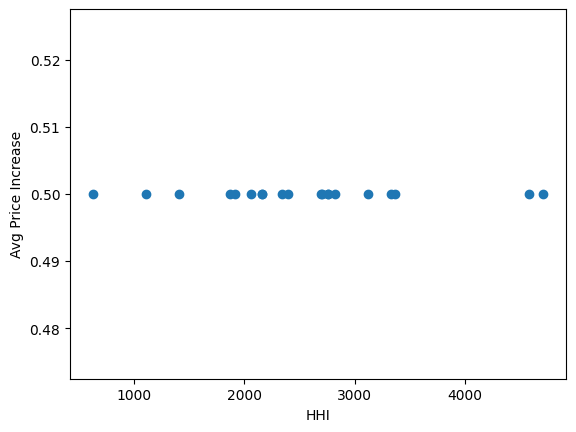

In [428]:
def calculateHHI(df):
    df2 = df.reset_index()
    M = df2.mktid.unique()
    HHI = []
    for mi,m in enumerate(M):
        s = np.array(df2[df2.mktid==m]['share'])*100
        HHI.append(np.sum(s**2))
    return HHI

HHI = np.array(calculateHHI(df))
plt.scatter(HHI, avgPriceInc)
plt.gca().set(ylabel='Avg Price Increase', xlabel='HHI')
plt.savefig("hhi.png")
plt.show()

In [429]:
HHI

array([1404.80753384, 2761.43571802, 2399.05824355, 2821.54432248,
       2062.9072442 , 2162.00494718, 1101.07713787, 2757.72765701,
       1869.81646818, 4583.82045038, 2338.56329786, 2694.64178594,
        620.07986192, 3366.61558967, 4717.11068418, 1913.72751589,
       3119.60484755, 2158.92462703, 3332.91928758, 2702.59605351])